## Table of Contents
- [1. Web scraping & data cleaning](#1)
- [2. Topic models](#2)
    - [2.1. LDA](#2.1)
    - [2.2. BTM](#2.2)
    - [2.3. NMF](#2.3)
    - [2.4. CorEx](#2.4)

### 1. Web scraping & data cleaning <a class="anchor" id="1"></a>

In [1]:
from bs4 import BeautifulSoup
import requests
from nltk.tokenize import word_tokenize
import re

#get list of character & season names so that they can be removed from text

#store names of characters & seasons here
char_tokens = []

#webpages for characters may be found on 2 pages
char_urls = ["https://americanhorrorstory.fandom.com/wiki/Category:Characters",
             "https://americanhorrorstory.fandom.com/wiki/Category:Characters?from=Mars%2C+Elsa%0AElsa+Mars"]

for url in char_urls:
    char_page = requests.get(url)
    char_soup = BeautifulSoup(char_page.content, "html.parser")

    char_list = char_soup.find("div", class_="category-page__members").text.replace("<br/>", "")
    char_list = re.sub(r'[^\w\s]', '', char_list).strip()

    tokens = word_tokenize(char_list.lower())
                
    for char in tokens:
        #do not append character names where len(char) == 1
        if len(char) > 1:
            char_tokens.append(char)
            

In [2]:
#number of episodes per season
seasons_episodes = [[1, 12], [2, 13], [3, 13], [4, 13], [5, 12], [6, 10], [7, 11], [8, 10]]
base_url = "https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=american-horror-story&episode="

#nltk stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#get extended list of stopwords (nltk's list is not so comprehensive)
additional_stopwords = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
additional_stopwords = additional_stopwords.decode().splitlines()
additional_stopwords = [re.sub(r'[^\w\s]', '', word) for word in additional_stopwords]
stop_words.extend(additional_stopwords)

#extra stopwords after conducting FreqDist (abbreviations of character names, exclamations, etc)
stop_words.extend(["english", "sdh", "retail", "subrip", "jeem", "baby", "gon", "hey",
          "yeah", "uh", "heh", "ha", "wan", "hmm", "huh",
          "damn", "â", "goddamn", "fuck", "shit", "fucking", "_",
          "viv", "judy", "briarcliff", "ozzie", "ivy", "delia", "marjorie"])

#add character & season names to stop word list
stop_words.extend(char_tokens)

#in preparation for lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#list of documents
data_words = []

for season in seasons_episodes:
    
    season_no = season[0]
    episodes = season[1]
    
    for episode in range(1, episodes + 1):
        
        #each episode will be a document
        episode_script = []
        
        if len(str(episode)) == 1: #prefix episode number with 0 if episode is single digit e.g. e01
            url = base_url + 's' + '0' + str(season_no) + 'e' + '0' + str(episode)
        else:
            url = base_url + 's' + '0' + str(season_no) +  'e' + str(episode)
        
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        
        doc = soup.find("div", class_="scrolling-script-container").text.replace("<br/>", "")
        
        #remove reactions/acting directions e.g. [GASPS], (COUGHS), etc.
        removed_reactions = re.sub(r'\[[^\]]*\]', '', doc)
        removed_reactions = re.sub(r'\([^)]*\)', '', removed_reactions)
        
        #remove numbers, punctuation
        removed_digits = re.sub(r'\d', '', removed_reactions)
        removed_punct = re.sub(r'[^\w\s]', '', removed_digits).strip()
        
        #tokenize
        tokens = word_tokenize(removed_punct.lower())

        #remove stopwords and single characters
        for t in tokens:
            if t not in stop_words and len(t) > 1:
                
                #lemmatize tokens
                lemmatized_token = lemmatizer.lemmatize(t)
                episode_script.append(lemmatized_token)
        
        #append episode to list of documents
        data_words.append(episode_script)
        
    print ('season', season_no, 'done') #helps track progress

season 1 done
season 2 done
season 3 done
season 4 done
season 5 done
season 6 done
season 7 done
season 8 done


In [ ]:
#write dataset to file
import csv
with open('dataset.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerows(data_words)

In [4]:
#check mean document length
import numpy as np
np.sum(len(ep) for ep in data_words) / len(data_words)

/var/folders/4w/gm8h7rpj357763xbhgq_jznm0000gn/T/ipykernel_95037/634474320.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(len(ep) for ep in data_words) / len(data_words)


993.0744680851063

### 2. Topic models <a class="anchor" id="2"></a>

### 2.1. LDA <a class="anchor" id="2.1"></a>

In [5]:
#LDA preprocessing
import gensim.corpora as corpora
from pprint import pprint

#create dictionary
id2word = corpora.Dictionary(data_words)

#term document frequency
texts = data_words

#create corpus
corpus = [id2word.doc2bow(text) for text in texts]

#view
print(corpus[:1][0][:30])


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 10), (8, 1), (9, 2), (10, 5), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 2), (24, 1), (25, 1), (26, 2), (27, 4), (28, 1), (29, 1)]


In [6]:
from gensim.models import CoherenceModel
from gensim import models

lda_perplexity_scores = []
lda_coherence_scores = []

for i in range(1, 51):
    num_topics = i
    
    #initialise and run LDA model
    lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word = id2word,
                                         num_topics=num_topics, random_state=100)

    #calculating model perplexity
    perplexity = lda_model.log_perplexity(corpus)
    lda_perplexity_scores.append(perplexity)
    
    #calculating model coherence
    cm = CoherenceModel(model=lda_model, dictionary=id2word, texts=texts, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    lda_coherence_scores.append(coherence)


In [7]:
#although there does not seem to be an optimal number of topics, we print topic words where topics = 5
#to check why this is so
lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word = id2word,
                                         num_topics=5, random_state=100)
pprint(lda_model.print_topics())


[(0,
  '0.009*"time" + 0.006*"thing" + 0.006*"people" + 0.005*"woman" + '
  '0.005*"good" + 0.005*"god" + 0.005*"love" + 0.004*"life" + 0.004*"night" + '
  '0.004*"girl"'),
 (1,
  '0.008*"time" + 0.007*"god" + 0.006*"life" + 0.005*"love" + 0.005*"thing" + '
  '0.005*"good" + 0.005*"girl" + 0.004*"feel" + 0.004*"woman" + '
  '0.004*"people"'),
 (2,
  '0.008*"time" + 0.006*"thing" + 0.005*"god" + 0.005*"people" + 0.004*"life" '
  '+ 0.004*"girl" + 0.004*"place" + 0.004*"good" + 0.004*"woman" + '
  '0.003*"wait"'),
 (3,
  '0.006*"time" + 0.006*"girl" + 0.006*"good" + 0.006*"god" + 0.005*"love" + '
  '0.005*"thing" + 0.005*"life" + 0.004*"people" + 0.004*"place" + '
  '0.003*"kill"'),
 (4,
  '0.009*"time" + 0.008*"thing" + 0.007*"god" + 0.006*"love" + 0.006*"good" + '
  '0.004*"people" + 0.004*"woman" + 0.004*"place" + 0.004*"feel" + '
  '0.004*"life"')]


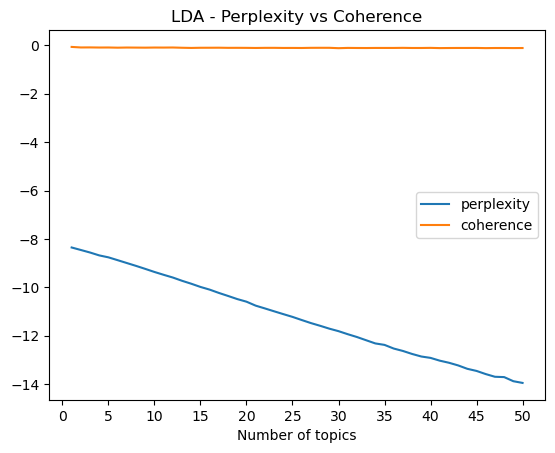

In [8]:
#plot perplexity against coherence for x topics
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(range(1, 51), lda_perplexity_scores, label = "perplexity")
plt.plot(range(1, 51), lda_coherence_scores, label = "coherence")
plt.xlabel('Number of topics')
ax.set_xticks(np.arange(0, 51, step=5))
plt.legend(loc='right')
plt.title('LDA - Perplexity vs Coherence')
plt.show()
#plt.savefig("plots/lda_pvsc.png")


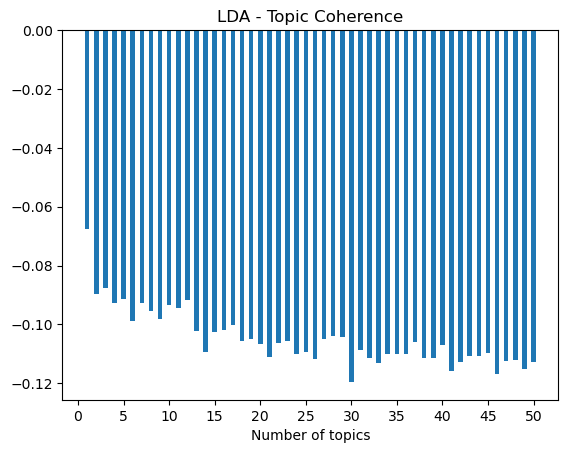

In [9]:
#looking at just topic coherence
fig, ax = plt.subplots()
plt.bar(range(1, 51), lda_coherence_scores, width=0.5)
plt.xlabel('Number of topics')
ax.set_xticks(np.arange(0, 51, step=5))
plt.title('LDA - Topic Coherence')
plt.show()
#plt.savefig("plots/lda_c.png")


### 2.2. BTM <a class="anchor" id="2.2"></a>

In [10]:
#BTM preprocessing
import bitermplus as btm
import numpy as np
import pandas as pd

#document list for BTM
btm_sentences = []

#break up episodes into sentences as otherwise the document is too long and the model doesn't run
for episode in data_words:
    episode_string = ' '.join(episode)
    btm_sentences.append(episode_string)

#obtain terms frequency in a sparse matrix and corpus vocabulary
X, vocabulary, vocab_dict = btm.get_words_freqs(btm_sentences)
tf = np.array(X.sum(axis=0)).ravel()

#vectorize documents
docs_vec = btm.get_vectorized_docs(btm_sentences, vocabulary)
docs_lens = list(map(len, docs_vec))

#generate biterms
biterms = btm.get_biterms(docs_vec)


In [11]:
btm_perplexity_scores = []
btm_coherence_scores = []

for i in range(1, 51):
    num_topics = i

    #initialise and run BTM model
    model = btm.BTM(X, vocabulary, seed=12321, T=num_topics, M=20, alpha=50/8, beta=0.01)
    model.fit(biterms, iterations=20)
    p_zd = model.transform(docs_vec)

    #calculating model perplexity
    perplexity = btm.perplexity(model.matrix_topics_words_, p_zd, X, num_topics)
    btm_perplexity_scores.append(perplexity)
    
    #calculating model coherence
    coherence = btm.coherence(model.matrix_topics_words_, X, M=20)
    #output is an array of scores - take the average
    avg_coherence = np.mean(coherence)
    btm_coherence_scores.append(avg_coherence)
    

100%|██████████████████████████████████████████| 94/94 [00:00<00:00, 212.01it/s]


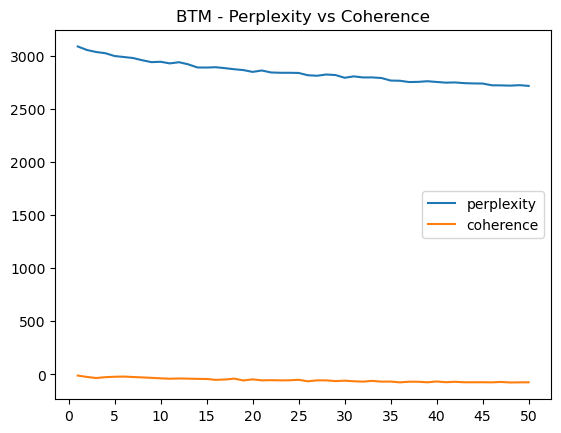

In [12]:
#plot perplexity against coherence for x topics

fig, ax = plt.subplots()
plt.plot(range(1, 51), btm_perplexity_scores, label = "perplexity")
plt.plot(range(1, 51), btm_coherence_scores, label = "coherence")
ax.set_xticks(np.arange(0, 51, step=5))
#ax.set_yticks(np.arange(-10, 0, step=2))
plt.legend(loc='right')
plt.title('BTM - Perplexity vs Coherence')
plt.show()
#plt.savefig("plots/btm_pvsc.png")


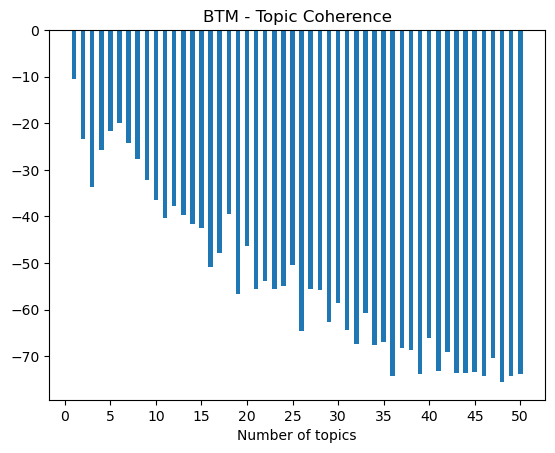

In [13]:
#looking at just topic coherence
fig, ax = plt.subplots()
plt.bar(range(1, 51), btm_coherence_scores, width=0.5)
plt.xlabel('Number of topics')
ax.set_xticks(np.arange(0, 51, step=5))
plt.title('BTM - Topic Coherence')
plt.show()
#plt.savefig("plots/btm_c.png")


In [14]:
#view results where number of topics = 5
model = btm.BTM(X, vocabulary, seed=12321, T=5, M=20, alpha=50/8, beta=0.01)
model.fit(biterms, iterations=20)
p_zd = model.transform(docs_vec)

import tmplot as tmp
tmp.report(model=model, docs=texts)


100%|█████████████████████████████████████████| 94/94 [00:00<00:00, 1342.13it/s]


In [15]:
#get topic words for topic n
n=4
phi = tmp.get_phi(model)
phi.head()

terms_probs = tmp.calc_terms_probs_ratio(phi, topic=n, lambda_=1)
terms_probs
#tmp.plot_terms(terms_probs)


Terms                                  Type  Probability
0         time       Marginal term probability, p(w)     0.046234
1        thing       Marginal term probability, p(w)     0.035540
2          god       Marginal term probability, p(w)     0.034152
3         good       Marginal term probability, p(w)     0.029273
4         girl       Marginal term probability, p(w)     0.024531
5         love       Marginal term probability, p(w)     0.029275
6         life       Marginal term probability, p(w)     0.026077
7        night       Marginal term probability, p(w)     0.018499
8         room       Marginal term probability, p(w)     0.012868
9        leave       Marginal term probability, p(w)     0.016208
10     thought       Marginal term probability, p(w)     0.019191
11       place       Marginal term probability, p(w)     0.021789
12       woman       Marginal term probability, p(w)     0.023123
13        year       Marginal term probability, p(w)     0.016123
14         boy       Marginal term probability, p(w)     0.013538
15        stay       Marginal term probability, p(w)     0.013269
16        real       Marginal term probability, p(w)     0.014173
17        wait       Marginal term probability, p(w)     0.011977
18      people       Marginal term probability, p(w)     0.026061
19      family       Marginal term probability, p(w)     0.013557
20        long       Marginal term probability, p(w)     0.012982
21        feel       Marginal term probability, p(w)     0.019441
22  understand       Marginal term probability, p(w)     0.011340
23        kill       Marginal term probability, p(w)     0.017328
24        kind       Marginal term probability, p(w)     0.010496
25       blood       Marginal term probability, p(w)     0.010456
26        told       Marginal term probability, p(w)     0.015718
27    happened       Marginal term probability, p(w)     0.011711
28        work       Marginal term probability, p(w)     0.016071
29      wanted       Marginal term probability, p(w)     0.014918
30        time  Conditional term probability, p(w|t)     0.010564
31       thing  Conditional term probability, p(w|t)     0.009033
32         god  Conditional term probability, p(w|t)     0.008158
33        good  Conditional term probability, p(w|t)     0.007626
34        girl  Conditional term probability, p(w|t)     0.006421
35        love  Conditional term probability, p(w|t)     0.006404
36        life  Conditional term probability, p(w|t)     0.004446
37       night  Conditional term probability, p(w|t)     0.004410
38        room  Conditional term probability, p(w|t)     0.004349
39       leave  Conditional term probability, p(w|t)     0.004295
40     thought  Conditional term probability, p(w|t)     0.004262
41       place  Conditional term probability, p(w|t)     0.004104
42       woman  Conditional term probability, p(w|t)     0.004071
43        year  Conditional term probability, p(w|t)     0.003986
44         boy  Conditional term probability, p(w|t)     0.003986
45        stay  Conditional term probability, p(w|t)     0.003933
46        real  Conditional term probability, p(w|t)     0.003874
47        wait  Conditional term probability, p(w|t)     0.003695
48      people  Conditional term probability, p(w|t)     0.003649
49      family  Conditional term probability, p(w|t)     0.003642
50        long  Conditional term probability, p(w|t)     0.003308
51        feel  Conditional term probability, p(w|t)     0.003251
52  understand  Conditional term probability, p(w|t)     0.003209
53        kill  Conditional term probability, p(w|t)     0.003139
54        kind  Conditional term probability, p(w|t)     0.003113
55       blood  Conditional term probability, p(w|t)     0.003047
56        told  Conditional term probability, p(w|t)     0.002921
57    happened  Conditional term probability, p(w|t)     0.002796
58        work  Conditional term probability, p(w|t)     0.002796
59      wanted  Conditional term probability, p(w

### 2.3. NMF <a class="anchor" id="2.3"></a>

In [16]:
#NMF preprocessing

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pandas as pd

#pass this tokenizer as our texts are already tokenized
def identity_tokenizer(text):
    return text

# Store TF-IDF Vectorizer of top 20000 words
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)  

# Fit and Transform text to a TF-IDF Doc-Term Matrix
data_tfidf = tfidf.fit_transform(data_words)

# Create data-frame of Doc-Term Matrix with nouns as column names
data_dtm = pd.DataFrame(data_tfidf.toarray(), columns=tfidf.get_feature_names())

# Visually inspect Document Term Matrix
data_dtm.head()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


aa  aaafter  aabsolutely  aah  aand  aarp  aat   ab  ababout  abacus  ...  \
0  0.0      0.0          0.0  0.0   0.0   0.0  0.0  0.0      0.0     0.0  ...   
1  0.0      0.0          0.0  0.0   0.0   0.0  0.0  0.0      0.0     0.0  ...   
2  0.0      0.0          0.0  0.0   0.0   0.0  0.0  0.0      0.0     0.0  ...   
3  0.0      0.0          0.0  0.0   0.0   0.0  0.0  0.0      0.0     0.0  ...   
4  0.0      0.0          0.0  0.0   0.0   0.0  0.0  0.0      0.0     0.0  ...   

   âprops  âshh  âtake  âthank  âthat  âthe  âwhat  âyeah      ãlan  ãle  
0     0.0   0.0    0.0     0.0    0.0   0.0    0.0    0.0  0.000000  0.0  
1     0.0   0.0    0.0     0.0    0.0   0.0    0.0    0.0  0.000000  0.0  
2     0.0   0.0    0.0     0.0    0.0   0.0    0.0    0.0  0.000000  0.0  
3     0.0   0.0    0.0     0.0    0.0   0.0    0.0    0.0  0.039335  0.0  
4     0.0   0.0    0.0     0.0    0.0   0.0    0.0    0.0  0.000000  0.0  

[5 rows x 13647 columns]

In [17]:
# NMF using gensim

nmf_perplexity_scores = []
nmf_coherence_scores = []

for i in range(1, 51):
    num_topics = i
    
    # Build NMF model
    nmf_model = models.nmf.Nmf(corpus=corpus, id2word = id2word, num_topics=num_topics)
    
    #calculating model coherence
    cm = CoherenceModel(model=nmf_model, dictionary=id2word, texts=texts, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    nmf_coherence_scores.append(coherence)


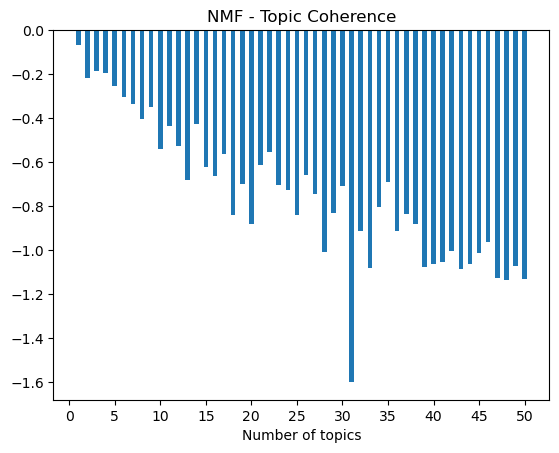

In [18]:
#looking at just topic coherence
fig, ax = plt.subplots()
plt.bar(range(1, 51), nmf_coherence_scores, width=0.5)
plt.xlabel('Number of topics')
ax.set_xticks(np.arange(0, 51, step=5))
plt.title('NMF - Topic Coherence')
plt.show()
#plt.savefig("plots/nmf_c.png")


In [19]:
def display_topics(model, feature_names, num_top_words,topic_names=None):
    """Given an NMF model, feature_names, and number of top words, print topic number 
    and its top feature names, up to specified number of top words.
    """
    
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, topic in enumerate(model.components_):        
        
        #print topic, topic number, and top words
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))


In [20]:
#view topic words where number of topics = 5
nmf_model = NMF(5)

# Learn an NMF model for given Document Term Matrix 'V' 
# Extract the document-topic matrix 'W'
doc_topic = nmf_model.fit_transform(data_dtm)

# Extract top words from the topic-term matrix 'H' 
display_topics(nmf_model, tfidf.get_feature_names(), 10)



Topic  0
love, time, thing, good, girl, halloween, life, place, twin, feel

Topic  1
supreme, witch, power, time, girl, wonder, life, voodoo, council, bitch

Topic  2
god, camera, moon, time, land, blood, real, wood, thing, people

Topic  3
trump, ruler, people, woman, divine, vote, election, time, valerie, gary

Topic  4
monsignor, time, patient, anne, thing, nun, god, doctor, good, woman


### 2.4. CorEx <a class="anchor" id="2.4"></a>

In [21]:
import scipy.sparse as ss
import corextopic.corextopic as ct
import corextopic.vis_topic as vt
from sklearn.feature_extraction.text import CountVectorizer

#vectorize texts
vectorizer = CountVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)    

#fit and transform text to a TF-IDF Doc-Term Matrix
doc_word = vectorizer.fit_transform(data_words)

doc_word = ss.csr_matrix(doc_word)

# Get words that label the columns (needed to extract readable topics and make anchoring easier)

words = list(np.asarray(vectorizer.get_feature_names()))


/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


In [22]:
corex_tc_scores = []

for i in range(1, 51):
    num_topics = i
    
    #build corex model
    topic_model = ct.Corex(n_hidden=num_topics, words=words, max_iter=10, verbose=False, seed=1) #set limit for max iter
    topic_model.fit(doc_word, words=words)
    
    #get tc scores
    tc = topic_model.tc 
    corex_tc_scores.append(tc)
    
    print('Number of topics:', num_topics, 'total correlation:', tc) #helps track progress

Number of topics: 1 total correlation: 96.7979411857839
Number of topics: 2 total correlation: 126.0354585829873
Number of topics: 3 total correlation: 145.0809798947372
Number of topics: 4 total correlation: 167.3155173455712
Number of topics: 5 total correlation: 170.21240943970025
Number of topics: 6 total correlation: 197.44157828538903
Number of topics: 7 total correlation: 183.7690636731065
Number of topics: 8 total correlation: 192.11214716230754
Number of topics: 9 total correlation: 214.31642477637746
Number of topics: 10 total correlation: 204.4116731439826
Number of topics: 11 total correlation: 211.37591416598505
Number of topics: 12 total correlation: 225.22826442142264
Number of topics: 13 total correlation: 243.86645353564717
Number of topics: 14 total correlation: 226.7127737974859
Number of topics: 15 total correlation: 233.89489196606624
Number of topics: 16 total correlation: 255.41012165009488
Number of topics: 17 total correlation: 222.3179609929565
Number of topic

In [23]:
#looking at just total correlation
fig, ax = plt.subplots()
plt.bar(range(1, 51), corex_tc_scores, width=0.5)
plt.xlabel('Number of topics')
ax.set_xticks(np.arange(0, 51, step=5))
plt.title('CorEx - Total correlation')
plt.show()
#plt.savefig("plots/corex_tc.png")


/var/folders/4w/gm8h7rpj357763xbhgq_jznm0000gn/T/ipykernel_95037/414015934.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [24]:
#view topics for model with 5 topics
topic_model = ct.Corex(n_hidden=5, words=words, max_iter=10, verbose=False, seed=1)
topic_model.fit(doc_word, words=words)

topics = topic_model.get_topics()

for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))    


0: drunk, helping, figured, unique, donated, obligation, specimen, outrageous, earn, professional
1: teach, meal, tall, oxygen, recording, library, aware, bath, nope, tea
2: blind, vein, chain, girl, shoulder, swamp, hurting, gate, protection, clock
3: crisis, assault, fault, friday, nurse, guard, tuesday, somethings, destroyed, goodness
4: personally, stood, raw, maker, garbage, case, week, staring, birthday, thethe
